In [1]:
import math
import random
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data{self.data})"
    
    def __neg__(self):
        return self * -1

    def __add__(self, other):
        # enable integer addition
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    # in the case of int * Value, __mul__ fails and python will swap the other of the
    # operands and tries __rmul__
    def __rmul__(self, other): # other * self
        return self * other 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        x = self.data
        v = math.pow(x, other)
        out = Value(v, (self, ), _op = f"^{other}")

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    
    def __rtruediv__(self, other):
        return self * other**-1
    
    def log(self):
        x = self.data
        if x <= 0:
            raise ValueError("Cannot take log of non-positive number")
        out = Value(math.log(x), (self, ), _op='log')
        
        def _backward():
            self.grad += (1/x) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out = Value(t, (self, ), _op = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def relu(self):
        x = self.data
        out = Value(max(0, x), (self, ), _op='relu')

        def _backward():
            self.grad += (x > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Use topological sort to reverse the order of nodes
        topo = []
        visited = set()

        def tbuild(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    tbuild(child)
                topo.append(v)

        tbuild(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [3]:
class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for i in range(nin)] # nin number of weights for nin number of edges coming into the neuron
        self.b = Value(random.uniform(-1, 1)) # only one bias is needed per neuron
    
    def __call__(self, x): # uses self(x) to call
        # wx+b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # output of the single neuron is the weighted, wi, sum of the inputs, xi: sum(wi,xi)
        out = act.tanh() # apply activation before returing output of the neuron; similar to Hebbian theory of a neuron
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer: 
    def __init__(self, nin, num): # num is the number of neurons in a single layer
        self.neurons = [Neuron(nin) for _ in range(num)] # a layer consisting of num number of neurons, each having nin inputs; list of neurons in the layer
    # Layer(a, b) makes a layer of b neurons, each of which takes a inputs

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # list of outputs from each neuron in the layer accessed from self.neurons
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # list of all parameters in the layer
    
class MLP: 
    def __init__(self, nin, size): # nin is the number of inputs, this forms the first layer; size is a list containing number of neurons in consecutive layers
        layers = [nin] + size # nin forms the first layer of inputs, layers is an exhaustive list of number of neurons in all layers
        self.layers = [Layer(layers[i], layers[i+1]) for i in range(len(size))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

### Example using Two Moons Dataset

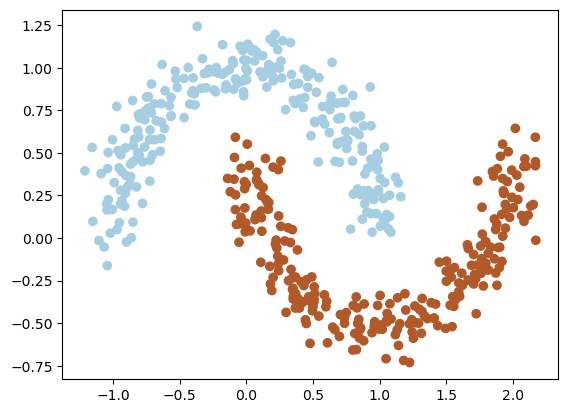

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [5]:
def focal_loss(y, ypred, gamma=2):
    # Emphasizes hard examples
    pred = (ypred + 1) / 2
    y = (y + 1) / 2
    return -((1 - pred)**gamma * y * pred.log() + pred**gamma * (1-y) * (1-pred).log())

def squared_hinge(y, ypred):
    # Smoother version of hinge loss
    return ((1.0 + (-y * ypred)).relu())**2 

def huber_loss(y, ypred, delta=1.0):
    # Combines MSE and MAE
    diff = y - ypred
    return (diff**2 / 2) if abs(diff.data) <= delta else (delta * abs(diff.data) - delta**2 / 2)

def mse(y, ypred):
    return (y - ypred)**2

In [9]:
def optimisation(model, X, y, iterations, lr = 0.01, batch_size = 10):
    # We are using tanh which has outputs b/w -1 and 1; but y is b/w 0 and 1 so we need to change it
    y = y * 2 - 1

    X = list(zip(list(map(Value, X[:, 0])), list(map(Value, X[:, 1]))))
    y = list(map(Value, y))

    for _ in range(iterations):
        # Initialise loss to 0
        loss = 0.0

        # Implement SGD
        idxs = random.sample(range(len(X)), batch_size)
        X_batch = [X[i] for i in idxs]
        y_batch = [y[i] for i in idxs]

        # Forward pass
        loss = sum(mse(y[i], model(X[i])) for i in idxs) / batch_size
        
        # Backpropagation
        loss.backward()

        # Update weights
        for p in model.parameters():
            p.data -= lr * p.grad
            p.grad = 0.0

        accuracy = sum(1.0 if (y[i].data > 0) == (model(X[i]).data > 0) else 0.0 for i in idxs) / batch_size
        print(f"Step {_} \t Loss: {loss.data} \t Accuracy: {accuracy}")

In [13]:
n = MLP(2, [16, 16, 1]) # 2 inputs, 8 neurons in each of the 3 layers, 1 output
optimisation(n, X, y, 25, lr=0.1)

Step 0 	 Loss: 0.7019267255993009 	 Accuracy: 0.9
Step 1 	 Loss: 0.19852145940660348 	 Accuracy: 1.0
Step 2 	 Loss: 0.6138170244485879 	 Accuracy: 0.8
Step 3 	 Loss: 0.21477259684823632 	 Accuracy: 1.0
Step 4 	 Loss: 0.16336320995803053 	 Accuracy: 1.0
Step 5 	 Loss: 0.267657585849706 	 Accuracy: 1.0
Step 6 	 Loss: 0.5823708571340628 	 Accuracy: 1.0
Step 7 	 Loss: 0.12470509053964703 	 Accuracy: 1.0
Step 8 	 Loss: 0.38076385355552755 	 Accuracy: 0.9
Step 9 	 Loss: 0.19608162532531007 	 Accuracy: 1.0
Step 10 	 Loss: 0.009721341344522093 	 Accuracy: 1.0
Step 11 	 Loss: 0.20668218624077675 	 Accuracy: 1.0
Step 12 	 Loss: 0.07257185897998834 	 Accuracy: 1.0
Step 13 	 Loss: 0.019523429979150877 	 Accuracy: 1.0
Step 14 	 Loss: 0.026702174511740007 	 Accuracy: 1.0
Step 15 	 Loss: 0.15095102297279567 	 Accuracy: 1.0
Step 16 	 Loss: 0.17413436947694097 	 Accuracy: 1.0
Step 17 	 Loss: 0.014400051677465671 	 Accuracy: 1.0
Step 18 	 Loss: 0.23014175779857374 	 Accuracy: 1.0
Step 19 	 Loss: 0.10477

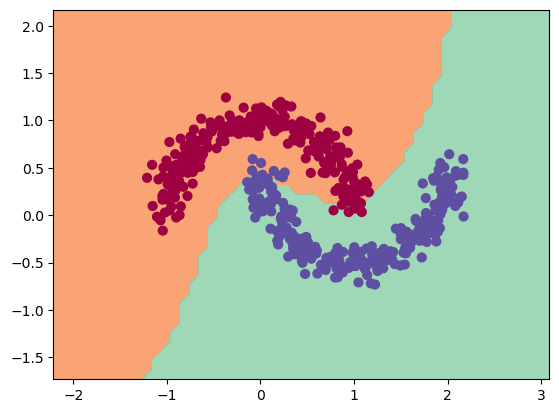

In [14]:
# h is the 'resolution' of the decision boundary 
h = 0.1

xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
xvals, yvals = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h)) # Create the grid of numbers

# Convert the grid to pairs of x, y coordinates, and then to Value objects
cplane = np.column_stack((xvals.ravel(), yvals.ravel()))
xin = [list(map(Value, coordinate)) for coordinate in cplane]
ypred = list(map(n, xin)) # Get the predictions

# Colour +/-
color = np.array([pred.data > 0 for pred in ypred])
color = color.reshape(xvals.shape)

plt.figure()
plt.contourf(xvals, yvals, color, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()